<a href="https://colab.research.google.com/github/mehreen89/DataSets/blob/main/mehreen_NLP_Hw7_1_2_Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a system that automatically classify whether a message is spam or not

# Different Fine-Tuning Techniques
1. Train the entire architecture – We can further train the entire pre-trained model on our dataset and feed the output to a softmax layer. In this case, the error is back-propagated through the entire architecture and the pre-trained weights of the model are updated based on the new dataset.
2. Train some layers while freezing others – Another way to use a pre-trained model is to train it partially. What we can do is keep the weights of initial layers of the model frozen while we retrain only the higher layers. We can try and test as to how many layers to be frozen and how many to be trained.
3. Freeze the entire architecture – We can even freeze all the layers of the model and attach a few neural network layers of our own and train this new model. Note that the weights of only the attached layers will be updated during model training.

In this tutorial, we will use the third approach. We will freeze all the layers of BERT during fine-tuning and append a dense layer and a softmax layer to the architecture.

# Install Transformers Library

!pip install transformers

In [ ]:
!pip install transformers
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")

# specify GPU
device = torch.device("cuda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00


# Load Dataset

In [ ]:
df = pd.read_csv("/content/sample_data/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(5572, 2)

In [ ]:
df['label'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

# Split train dataset into train, validation, and test sets

In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2023,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2023,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Example to see how the BERT tokenizer works

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


1. ‘input_ids’ contains the integer sequences of the input sentences. The integers 101 and 102 are special tokens. We add them to both the sequences, and 0 represents the padding token.
2. ‘attention_mask’ contains 1’s and 0’s. It tells the model to pay attention to the tokens corresponding to the mask value of 1 and ignore the rest.

# Tokenize the Sentences

<Axes: >

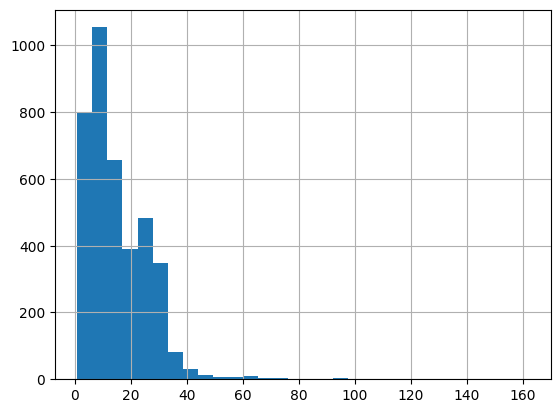

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins =30)

In [ ]:
max_seq_len = 25

Convert the messages in train, validation, and test set to integer sequences of length 25 tokens each

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

Now we will create dataloaders for both train and validation set. These dataloaders will pass batches of train data and validation data as input to the model during the training phase.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# create the DataLoader for our training set
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# # create the DataLoader for our training set
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

we will freeze all the layers of the model before fine-tuning it !

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

The above will prevent updating of model weights during fine-tuning. if you wish to fine-tune even the pre-trained weights of the BERT model then you should not execute the code above !

In [ ]:
# To freeze any specific layers

#for name, param in model.named_parameters():
#    if name.startswith(“bert.encoder.layer.1”):
#    param.requires_grad = False
#    if name.startswith(“bert.encoder.layer.2”):
#    param.requires_grad = False

# Define Model Architecture

### Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and additional custom feed-forward layers are added to the network

In [ ]:
# Create the BertClassifier class
class BERT_Arch(nn.Module):
    """Bert model for Classification Tasks
    """
    #def __init__(self,freeze_bert=False):
    def __init__(self, bert):

      super(BERT_Arch, self).__init__()
      # Instantiate the BERT model
      #self.bert = AutoModel.from_pretrained('bert-base-uncased')
      self.bert = bert

      # Custom layer
      self.dropout = nn.Dropout(0.1) # dropout layer
      self.relu =  nn.ReLU() # relu activation function
      self.fc1 = nn.Linear(768,512) # dense layer 1
      self.fc2 = nn.Linear(512,2)  # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

      ## Freeze the BERT model
       # if freeze_bert:
       #     for param in self.bert.parameters():
       #         param.requires_grad = Flase

    #define the forward pass
    def forward(self, sent_id, mask):
        """
        #Feed input to BERT and the classifier to compute logits.
        @param  sent_id (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
       """
      #Feed input to BERT
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      # the output from BERT's [CLS] token is passed through custom layers
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
      # output layer
        x = self.fc2(x)
      # apply softmax activation - logits are outputted !
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

There is a class imbalance in our dataset. The majority of the observations are not spam. So, we will first compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced',
                                 classes = np.unique(train_labels),
                                 y = train_labels)


print(class_wts)

[0.57743559 3.72848948]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine-Tune BERT

So, till now we have defined the model architecture, we have specified the optimizer and the loss function, and our dataloaders are also ready. Now we have to define a couple of functions to train (fine-tune) and evaluate the model, respectively.

Training:

1. Unpack our data from the dataloader and load the data onto the GPU
2. Zero out gradients calculated in the previous pass
3. Perform a forward pass to compute logits and loss
4. Perform a backward pass to compute gradients (loss.backward())
5. Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
6. Update the model's parameters (optimizer.step())
7. Update the learning rate (scheduler.step())

Evaluation:

1. Unpack our data and load onto the GPU
2. Forward pass
3. Compute loss and accuracy rate over the validation set

In [ ]:
# function to train the model
def train():

    model.train()
  # put the model into the training mode
  # it tells your model that you are training the model.
  # This helps inform layers such as Dropout and BatchNorm,
  # which are designed to behave differently during training and evaluation.
  # For instance, in training mode, BatchNorm updates a moving average on each new batch;
  # whereas, for evaluation mode, these updates are frozen.

    total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
    total_preds=[]
  # iterate over batches
    for step,batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
      if step % 50 == 0 and not step == 0:
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
    return avg_loss, total_preds

We will use the following function to evaluate the model. It will use the validation set data.

In [ ]:
# function for evaluating the model

def evaluate():
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    print("\nEvaluating...")

  # put the model into the evaluation mode. The dropout layers are disabled during the test time
    model.eval()

    total_loss, total_accuracy = 0, 0
  # empty list to save the model predictions
    total_preds = []
  # iterate over batches
    for step,batch in enumerate(val_dataloader):
    # Progress update every 50 batches.
      if step % 50 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
         elapsed = format_time(time.time() - t0)
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      # model predictions / compute logits
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      # get predictions
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

   # compute the validation loss of the epoch
      avg_loss = total_loss / len(val_dataloader)

   # reshape the predictions in form of (number of samples, no. of classes)
      total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Start Model Training

Now we will finally start fine-tuning of the model.

In [ ]:
#This code will correctly tokenize the texts and train
#the BERT model for sequence classification.
#Make sure transformers are installed.

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification

# Instantiate the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example text
texts = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "U dun say so early hor... U c already then say...",
    "Nah I don't think he goes to usf, he lives around here though",
    "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun"
]
#fix the issue, ensure that all tensors are on the same device.

# Encode the texts
encoded_texts = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Extract the input IDs, attention masks, and labels
input_ids = encoded_texts['input_ids'].to('cuda')
attention_masks = encoded_texts['attention_mask'].to('cuda')
labels = torch.tensor([0, 0, 1, 0, 0, 1]).to('cuda')  # Example labels (0 or 1)

# Create a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Set batch size and create a DataLoader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to('cuda')

# Training loop
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    for batch in dataloader:
        batch = tuple(t.to('cuda') for t in batch)  # Move the batch to GPU

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

    print(f"Training Loss: {loss.item():.3f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i


Epoch 1/10
Training Loss: 0.620

Epoch 2/10
Training Loss: 0.557

Epoch 3/10
Training Loss: 0.484

Epoch 4/10
Training Loss: 0.393

Epoch 5/10
Training Loss: 0.339

Epoch 6/10
Training Loss: 0.275

Epoch 7/10
Training Loss: 0.258

Epoch 8/10
Training Loss: 0.216

Epoch 9/10
Training Loss: 0.189

Epoch 10/10
Training Loss: 0.186


You can see that the validation loss is still decreasing at the end of the 10th epoch. So, you may try a higher number of epochs. Now let’s see how well it performs on the test dataset.

# Make Predictions

To make predictions, we will first of all load the best model weights which were saved during the training process.



In [ ]:
#load weights of best model
#the model weights will be saved at the end of each epoch in the
#file named 'saved_weights.pt' in the current directory.

# Training loop
for epoch in range(epochs):
    # Perform training steps

    # Save model weights
    path = 'saved_weights.pt'
    torch.save(model.state_dict(), path)



# Get Predictions for Test Data

In [ ]:
# Get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  logits = preds.logits
  preds = logits.detach().cpu().numpy()


Check the model performance

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       724
           1       0.70      0.40      0.51       112

    accuracy                           0.90       836
   macro avg       0.81      0.69      0.73       836
weighted avg       0.89      0.90      0.88       836



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,705,19
1,67,45


Both recall and precision for class 1 are quite high which means that the model predicts this class pretty well. However, our objective was to detect spam messages, so misclassifying class 1 (spam) samples is a bigger concern than misclassifying class 0 samples. If you look at the recall for class 1, it is 0.90 which means that the model was able to correctly classify 90% of the spam messages. However, precision is a bit on the lower side for class 1. It means that the model misclassifies some of the class 0 messages (not spam) as spam.